In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
def buildDataset(words):
    block_size = 3
    x, y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            x.append(context)
            y.append(ix)
            #print(''.join ([itos[i] for i in context]), '-->', itos[ix])
            context = context[1:] + [ix]
            
    x = torch.tensor(x)
    y = torch.tensor(y)
    print(x.shape, y.shape)
    return x, y
import random
random.seed(42)
random.shuffle(words)
n1 = int (len(words)*.8)    
n2 = int (len(words)*.9)    
x_train, y_train = buildDataset(words[:n1])
x_val, y_val = buildDataset(words[n1:n2])
x_test, y_test = buildDataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [23]:
class Linear:
    def __init__(self, in_features, out_features, bias = True):
        self.weight = torch.randn(in_features, out_features) / in_features**.5
        self.bias = torch.zeros(out_features)
        
    def call(self, x):
        return x @ self.weight + self.bias
    
    def parameters(self):
        return [self.weight] + ([]if self.bias is None else [self.bias])
    
class BatchNorm1D:
    def __init__(self, num_features, momentum = 0.1, eps = 1e-5):
        self.momentum = momentum
        self.eps = eps
        self.training = True
        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)
        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)
        
    def call(self, x):
        if self.training:
            xmean = x.mean(0)
            xvar = x.var(0)
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * xmean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * xvar
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / (xvar + self.eps)**.5
        if self.training:
            with torch.no_grad():
                self.running_mean = self.momentum + self.running_mean * (1 - self.momentum) * xmean
                self.running_var = self.momentum + self.running_var * (1 - self.momentum) * xvar
        return xhat * self.gamma + self.beta
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class TanH:
    def call(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [24]:
n_embd = 10
n_hidden = 200

C = torch.randn(len(itos), n_embd)
layers = [Linear(n_embd * block_size, n_hidden), TanH(), Linear(n_hidden, len(itos))]

with torch.no_grad():
    layers[-1].weight *= 0.1
    
    
    
params = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in params))
for p in params:
    p.requires_grad = True

11897


In [ ]:
lri, lossi, stepi = [], [], []

for i in range(200000):
    # Constructing a mini-batch
    ix = torch.randint(0, len(x_train), (32,))
    emb = C[x_train[ix]]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer.call(x)
    loss = F.cross_entropy(x, y_train[ix])
    for p in params:
        p.grad = None
    loss.backward()
    lr = .1
    for p in params:
        p.data += -lr * p.grad
    stepi.append(i)
    #lri.append(lre[i])
    lossi.append(loss.log10().item())
    if i % 10000 == 0:
        print(i, loss.item())
        lr *= 0.95


0 2.419327735900879
10000 2.211097240447998
20000 2.374601364135742
30000 1.9630528688430786
40000 1.9265552759170532
50000 1.8409568071365356
60000 1.9745879173278809
70000 1.9756969213485718
80000 2.4776034355163574
90000 2.0903468132019043
100000 1.7549002170562744
110000 2.1976664066314697
120000 2.128587484359741
130000 2.5364928245544434
140000 2.0718045234680176
150000 1.9549674987792969
160000 1.9612271785736084
170000 2.064079523086548
180000 2.094541549682617
190000 1.8247569799423218


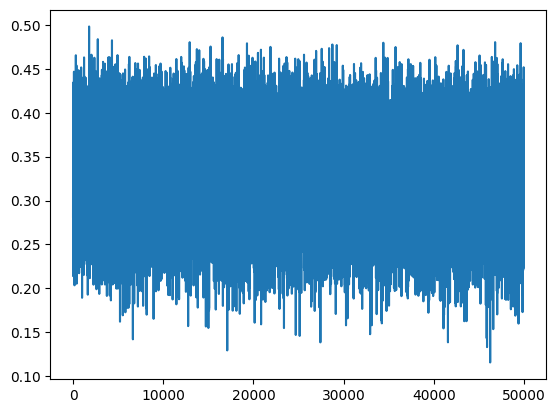

In [27]:
plt.plot(lossi)

In [28]:
for layer in layers:
    layer.training = False

In [29]:
@torch.no_grad()
def splitLoss(split):
    x,y = {
        'train': (x_train, y_train),
        'val': (x_val, y_val),
        'test': (x_test, y_test)
    }[split]
    emb = C[x]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer.call(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())
    
splitLoss('train')
splitLoss('val')

train 2.1367199420928955
val 2.1816868782043457
